# MVTec Anomaly Detection Analysis

This notebook projects solutions for resolving class imabalance using anomaly detection adapted for the MVTec Anomaly Detection dataset.

## 1. Imports and Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mode
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torch
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")
# Set random seed for reproducibility
np.random.seed(42)
# Set display options
pd.set_option('display.max_columns', None)


Using Device: cuda


## 2. Load MVTec Dataset and Data Preprocessing for Grayscale Images with Pretrained CNNs
We assume the dataset is extracted in `./mvtec` with subfolders for each category. 

Pretrained CNNs like ResNet expect 3-channel RGB input. To use grayscale images, convert them to 3 channels by duplicating the single channel. Normalize using three identical means and stds. This ensures compatibility and leverages pretrained weights.

In [2]:
# Example for 'bottle' category
data_dir = './mvtec_anomaly_detection/bottle'  # Adjust the path as needed
transform = transforms.Compose([
    transforms.Grayscale(),              # [1, H, W]
    transforms.Resize((224, 224)),       # all images → 224×224
    #transforms.RandomHorizontalFlip(), 
    #transforms.RandomRotation(20),
    transforms.ToTensor(),                                # FloatTensor [1,224,224] in [0.0–1.0]
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),       # now [3,224,224], duplicating the single channel 
    transforms.Normalize(mean=(0.5, 0.5, 0.5),            # use three identical means
                        std=(0.5, 0.5, 0.5))               # and stds for RGB normalization
])            

# Normal (train) and Test (normal + anomaly)
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 209, Test samples: 83


## 3. Visualize Sample Images

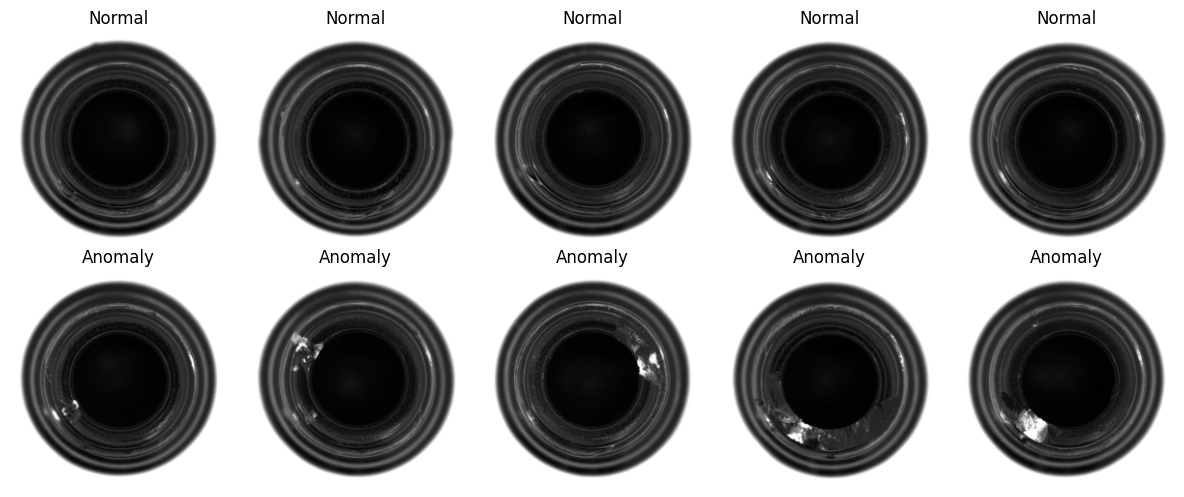

In [3]:
# Show some normal and anomalous examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
# Normal examples
for i in range(5):
    img, _ = train_dataset[i]
    gray = img[0].cpu().numpy()   # taking channel 0 to shape (128,128)
    axes[0, i].imshow(gray, cmap='gray')
    axes[0, i].set_title('Normal')
    axes[0, i].axis('off')
# Anomalous examples from test set (label 1)
anomaly_indices = [i for i, (_, label) in enumerate(test_dataset) if label==1][:5]
for i, idx in enumerate(anomaly_indices):
    img, _ = test_dataset[idx]
    gray = img[0].cpu().numpy()
    axes[1, i].imshow(gray, cmap='gray')
    axes[1, i].set_title('Anomaly')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


## 4. Feature Extraction using a Pretrained CNN

In [4]:
# Use pretrained ResNet34, remove final layer
resnet = models.resnet34(pretrained=True)
#resnet = models.resnet18(pretrained=True)

resnet.fc = torch.nn.Identity()
resnet.eval()
resnet = resnet.to(device)

def extract_features(loader):
    features = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            feats = resnet(imgs)
            features.append(feats.cpu().numpy())
            labels.extend(lbls.cpu().numpy())
    return np.concatenate(features, axis=0), np.array(labels)

X_train_feats, y_train_feats = extract_features(train_loader)
X_test_feats, y_test_feats = extract_features(test_loader)
print("Feature shapes:", X_train_feats.shape, X_test_feats.shape)


f:\Minconda\envs\tf_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\Minconda\envs\tf_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature shapes: (209, 512) (83, 512)


## 5. Training Models

### 5.1 Train One-Class SVM on Normal Features

In [5]:

scaler = StandardScaler()
X_train_feats = scaler.fit_transform(X_train_feats)
X_test_feats = scaler.transform(X_test_feats)


X_train_normal = X_train_feats[y_train_feats == 0]

svm = OneClassSVM(nu=0.1, kernel="rbf", gamma='scale')
svm.fit(X_train_normal)

#Predict on the test set
y_pred_svm = svm.predict(X_test_feats)
y_pred_svm = np.where(y_pred_svm == 1, 0, 1)  # Convert to binary labels: 0 for normal, 1 for anomaly

print(" One-Class SVM Model Trained!")


 One-Class SVM Model Trained!


### 5.2 Train Isolation Forest on Normal Features

In [6]:
# Reduce dimensionality of features
pca = PCA(n_components=0.95, svd_solver='full')  # retain 95% variance
X_train_pca = pca.fit_transform(X_train_feats)
X_test_pca = pca.transform(X_test_feats)

iso = IsolationForest(contamination=0.01, n_estimators=200, max_samples='auto', random_state=42)
iso.fit(X_train_pca)

# Predict: -1 for anomaly, 1 for normal
test_pred = iso.predict(X_test_pca)
y_pred = np.where(test_pred == 1, 0, 1)  # map to 0/1


### 5.3 Train Elliptic Envelope on Normal Features

In [7]:
pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train_normal)

# 2. Transform entire test set
X_test_pca = pca.transform(X_test_feats)

# 3. Fit EllipticEnvelope on the reduced data
ee = EllipticEnvelope(contamination=0.1, random_state=42)
ee.fit(X_train_pca)

# 4. Predict
y_pred_eee = ee.predict(X_test_pca)
y_pred_eee = (y_pred_eee == -1).astype(int)

### 5.4 Train Local outlier Factor on normal features

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feats)
X_test_scaled = scaler.transform(X_test_feats)

# Fit LOF on training features (unsupervised, so use all train data)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)
lof.fit(X_train_feats)

# Predict on test set
y_pred_lof = lof.predict(X_test_feats)
y_pred_lof = np.where(y_pred_lof == 1, 0, 1)  # 0=normal, 1=anomaly

In [9]:
# Identify which index in ImageFolder corresponds to 'good'
good_idx = test_dataset.class_to_idx['good']  
# e.g. good_idx == 0, but let’s fetch it dynamically

# Create a binary true-label array
y_test_bin = (y_test_feats != good_idx).astype(int)

## 6. Evaluation

### 6.1 Evaluate One-Class SVM Results

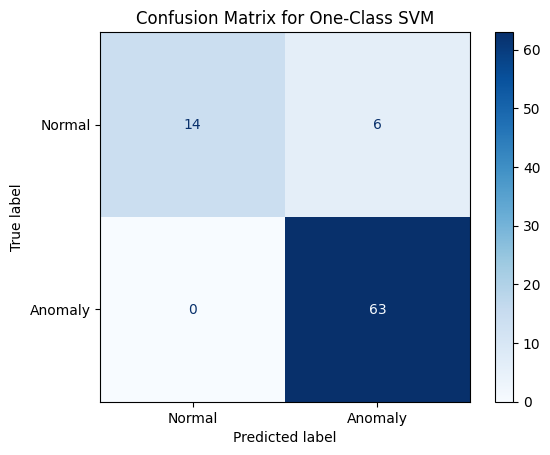

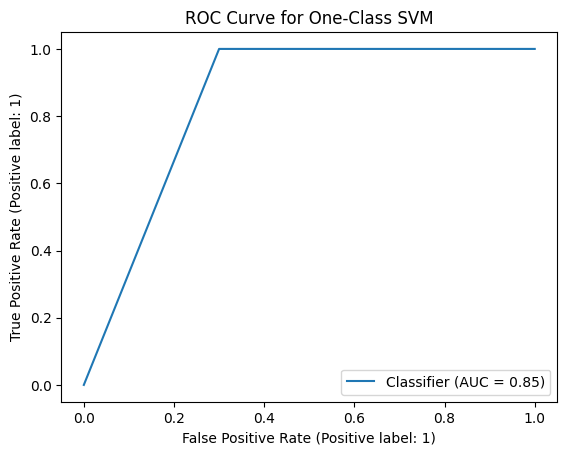

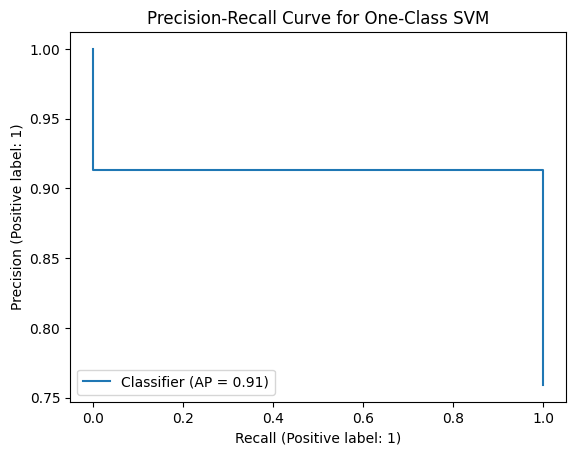

One-Class SVM Accuracy: 0.9277
Classification Report: 
              precision    recall  f1-score   support

      Normal       1.00      0.70      0.82        20
     Anomaly       0.91      1.00      0.95        63

    accuracy                           0.93        83
   macro avg       0.96      0.85      0.89        83
weighted avg       0.93      0.93      0.92        83

ROC-AUC: 0.85


In [10]:
accuracy = accuracy_score(y_test_bin, y_pred_svm)

cm = confusion_matrix(y_test_bin, y_pred_svm)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for One-Class SVM')

roc_curve = RocCurveDisplay.from_predictions(y_test_bin, y_pred_svm)
plt.title('ROC Curve for One-Class SVM')

pr_curve = PrecisionRecallDisplay.from_predictions(y_test_bin, y_pred_svm)
plt.title('Precision-Recall Curve for One-Class SVM')
plt.show()


print(f"One-Class SVM Accuracy: {accuracy:.4f}")
print(f"Classification Report: \n{classification_report(y_test_bin, y_pred_svm, target_names=['Normal','Anomaly'])}")
print("ROC-AUC:", roc_auc_score(y_test_bin, y_pred_svm))

### 6.2 Evaluate Isolation Forest Results

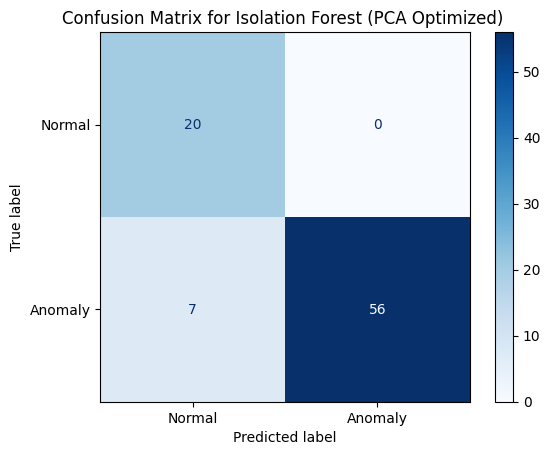

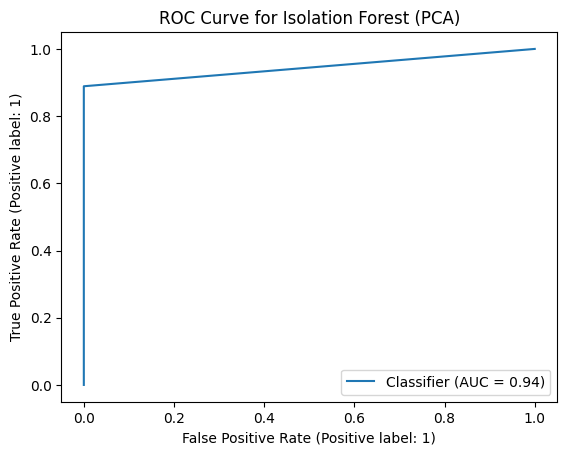

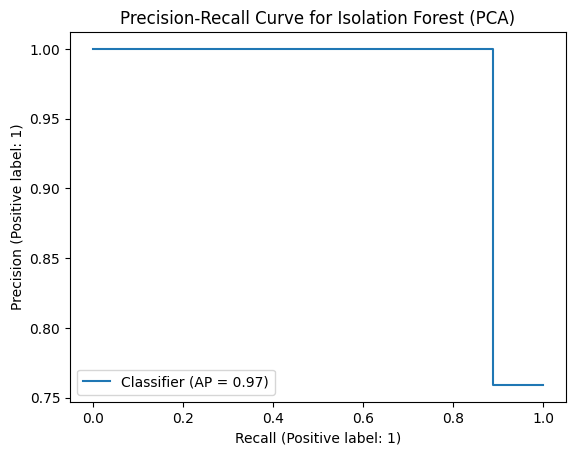

Isolation Forest (PCA) Accuracy: 0.9157
Classification Report: 
              precision    recall  f1-score   support

      Normal       0.74      1.00      0.85        20
     Anomaly       1.00      0.89      0.94        63

    accuracy                           0.92        83
   macro avg       0.87      0.94      0.90        83
weighted avg       0.94      0.92      0.92        83

ROC-AUC: 0.9444444444444444


In [11]:
accuracy = accuracy_score(y_test_bin, y_pred)

cm = confusion_matrix(y_test_bin, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Isolation Forest (PCA Optimized) ')

roc_curve = RocCurveDisplay.from_predictions(y_test_bin, y_pred)
plt.title('ROC Curve for Isolation Forest (PCA)')

pr_curve = PrecisionRecallDisplay.from_predictions(y_test_bin, y_pred)
plt.title('Precision-Recall Curve for Isolation Forest (PCA)')
plt.show()

print(f"Isolation Forest (PCA) Accuracy: {accuracy:.4f}")
print(f"Classification Report: \n{classification_report(y_test_bin, y_pred, target_names=['Normal','Anomaly'])}")
print("ROC-AUC:", roc_auc_score(y_test_bin, y_pred))

### 6.3 Ensemble Methods for Anomaly Detection

Ensemble methods combine predictions from multiple models to improve robustness and accuracy. For anomaly detection, you can combine Isolation Forest and One-Class SVM using majority voting or averaging their anomaly scores.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20424\270437958.py:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_pred_ensemble = mode(ensemble_preds, axis=0)[0].flatten()


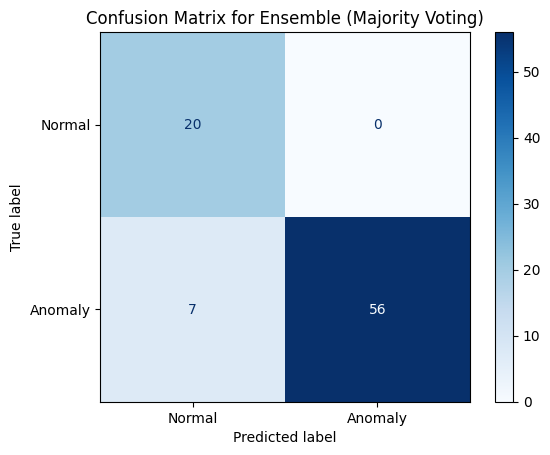

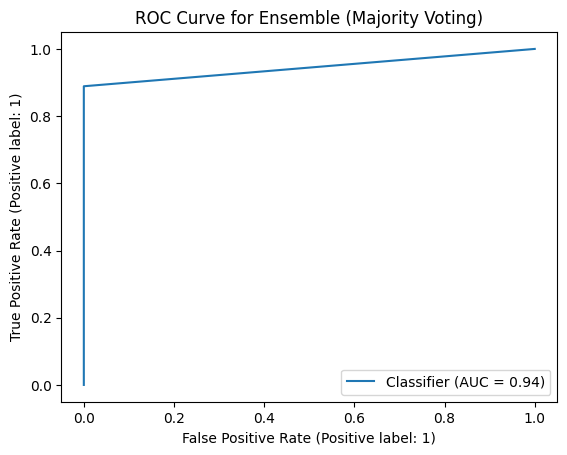

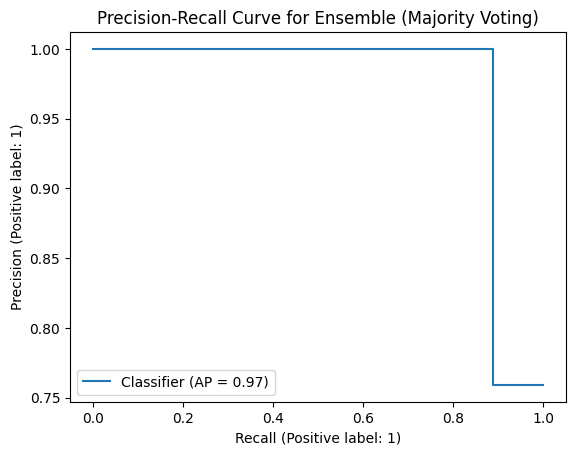

Ensemble Accuracy: 0.9157
Classification Report: 
              precision    recall  f1-score   support

      Normal       0.74      1.00      0.85        20
     Anomaly       1.00      0.89      0.94        63

    accuracy                           0.92        83
   macro avg       0.87      0.94      0.90        83
weighted avg       0.94      0.92      0.92        83

ROC-AUC: 0.9444444444444444


In [12]:
# Get predictions from both models (ensure y_pred and y_pred_svm are binary: 0=normal, 1=anomaly)
ensemble_preds = np.vstack([y_pred, y_pred_svm])
y_pred_ensemble = mode(ensemble_preds, axis=0)[0].flatten()

# Evaluate ensemble results
accuracy = accuracy_score(y_test_bin, y_pred_ensemble)
cm = confusion_matrix(y_test_bin, y_pred_ensemble)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Ensemble (Majority Voting)')

roc_curve = RocCurveDisplay.from_predictions(y_test_bin, y_pred_ensemble)
plt.title('ROC Curve for Ensemble (Majority Voting)')
pr_curve = PrecisionRecallDisplay.from_predictions(y_test_bin, y_pred_ensemble)
plt.title('Precision-Recall Curve for Ensemble (Majority Voting)')


plt.show()

print(f"Ensemble Accuracy: {accuracy:.4f}")
print(f"Classification Report: \n{classification_report(y_test_bin, y_pred_ensemble, target_names=['Normal','Anomaly'])}")
print("ROC-AUC:", roc_auc_score(y_test_bin, y_pred_ensemble))

### 6.4 Evaluate Elliptic Envelope Results

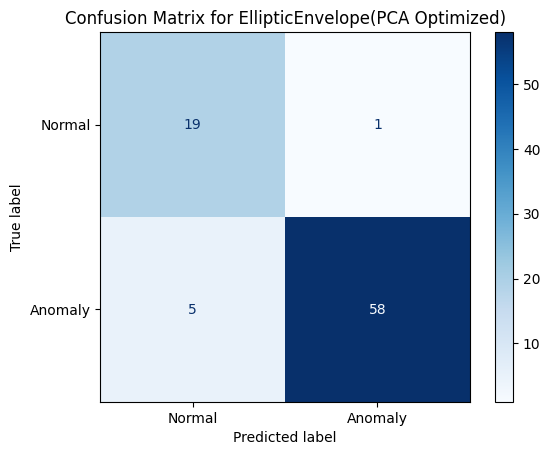

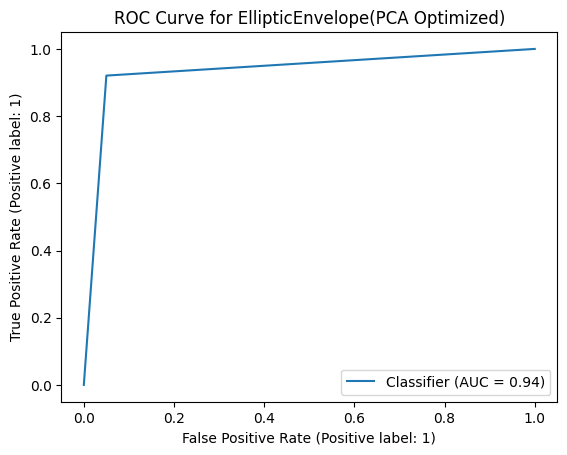

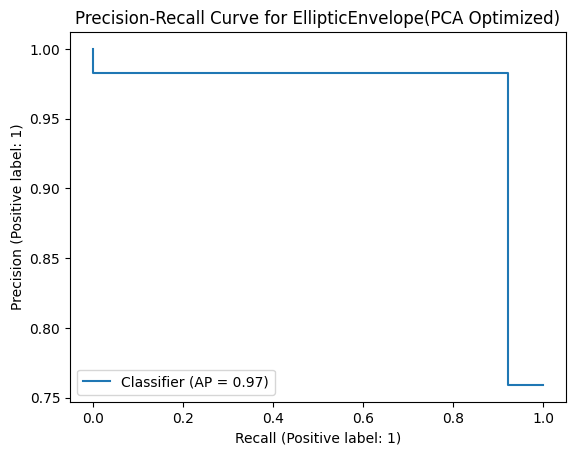

EllipticEnvelope Accuracy: 0.9277
Classification Report: 
              precision    recall  f1-score   support

      Normal     0.7917    0.9500    0.8636        20
     Anomaly     0.9831    0.9206    0.9508        63

    accuracy                         0.9277        83
   macro avg     0.8874    0.9353    0.9072        83
weighted avg     0.9369    0.9277    0.9298        83

ROC-AUC: 0.9353174603174602


In [13]:
# Evaluate EllipticEnvelope results
accuracy = accuracy_score(y_test_bin, y_pred_eee)
cm = confusion_matrix(y_test_bin, y_pred_eee)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for EllipticEnvelope(PCA Optimized)')

roc_curve = RocCurveDisplay.from_predictions(y_test_bin, y_pred_eee)
plt.title('ROC Curve for EllipticEnvelope(PCA Optimized)')
pr_curve = PrecisionRecallDisplay.from_predictions(y_test_bin, y_pred_eee)
plt.title('Precision-Recall Curve for EllipticEnvelope(PCA Optimized)')


plt.show()

print(f"EllipticEnvelope Accuracy: {accuracy:.4f}")
print(f"Classification Report: \n{classification_report(y_test_bin, y_pred_eee, target_names=['Normal','Anomaly'], digits=4 )}")
print("ROC-AUC:", roc_auc_score(y_test_bin, y_pred_eee))

### 6.5 Evaluate LOF Results

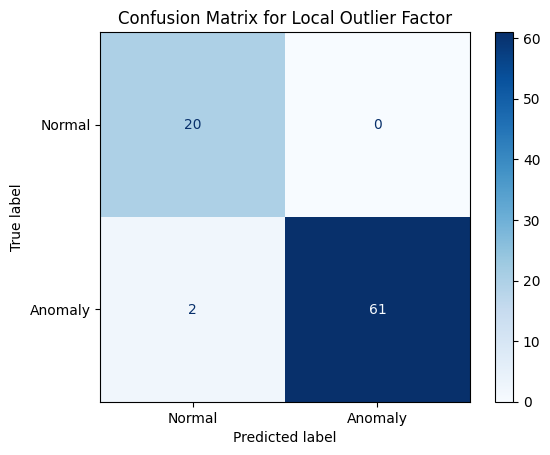

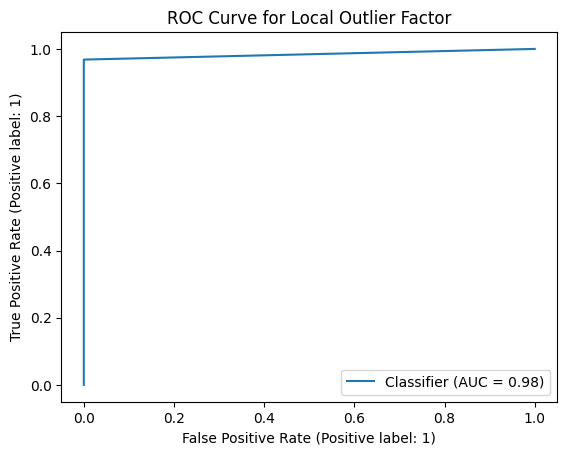

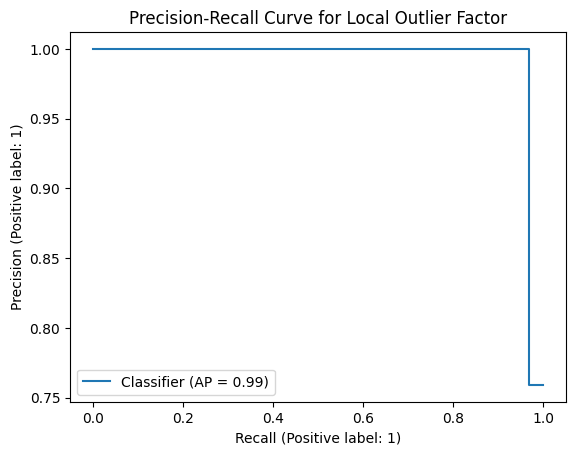

LOF Accuracy: 0.9759
Classification Report: 
              precision    recall  f1-score   support

      Normal       0.91      1.00      0.95        20
     Anomaly       1.00      0.97      0.98        63

    accuracy                           0.98        83
   macro avg       0.95      0.98      0.97        83
weighted avg       0.98      0.98      0.98        83

ROC-AUC: 0.9841269841269842


In [14]:

# Fit LOF on training features (unsupervised, so use all train data)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)
lof.fit(X_train_feats)

# Predict on test set
y_pred_lof = lof.predict(X_test_feats)
y_pred_lof = np.where(y_pred_lof == 1, 0, 1)  # 0=normal, 1=anomaly

# Evaluate LOF results
accuracy = accuracy_score(y_test_bin, y_pred_lof)
cm = confusion_matrix(y_test_bin, y_pred_lof)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Local Outlier Factor')

roc_curve = RocCurveDisplay.from_predictions(y_test_bin, y_pred_lof)
plt.title('ROC Curve for Local Outlier Factor')

pr_curve = PrecisionRecallDisplay.from_predictions(y_test_bin, y_pred_lof)
plt.title('Precision-Recall Curve for Local Outlier Factor')

plt.show()

print(f"LOF Accuracy: {accuracy:.4f}")
print(f"Classification Report: \n{classification_report(y_test_bin, y_pred_lof, target_names=['Normal','Anomaly'], zero_division=0)}")
print("ROC-AUC:", roc_auc_score(y_test_bin, y_pred_lof))

In [15]:
import openpyxl

def evaluate_and_store(model_name, y_true, y_pred, results_list):
    report = classification_report(
        y_true, y_pred,
        target_names=['Normal','Anomalous'],
        output_dict=True,  # returns a dict, not a string
        zero_division=0
    )
    auc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[1,-1])
    
    results_list.append({
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Normal_Precision": report["Normal"]["precision"],
        "Normal_Recall": report["Normal"]["recall"],
        "Normal_F1": report["Normal"]["f1-score"],
        "Anomaly_Precision": report["Anomalous"]["precision"],
        "Anomaly_Recall": report["Anomalous"]["recall"],
        "Anomaly_F1": report["Anomalous"]["f1-score"],
        "Macro_F1": report["macro avg"]["f1-score"],
        "Weighted_F1": report["weighted avg"]["f1-score"],
        "ROC_AUC": auc,
        "Confusion_Matrix": cm.tolist()
    })


# 1) Collect results
results = []

# Example: LOF
evaluate_and_store("LocalOutlierFactor", y_test_bin, y_pred_lof, results)

# Example: IsolationForest
evaluate_and_store("IsolationForest_PCA", y_test_bin, y_pred, results)

# Example: One-Class SVM
evaluate_and_store("OneClassSVM", y_test_bin, y_pred_svm, results)

# Example: EllipticEnvelope (PCA Optimized)
evaluate_and_store("EllipticEnvelope_PCA", y_test_bin, y_pred_eee, results)

#Example: Ensemble(Majority Voting[IsolationForest and OneClassSVM])
evaluate_and_store("Ensemble", y_test_bin, y_pred_ensemble, results)



# 2) Convert to DataFrame
df_results = pd.DataFrame(results)

# 3) Export
df_results.to_csv("model_results_mvtec_AD.csv", index=False)
df_results.to_excel("model_resultsmvtec_AD.xlsx", index=False)

print("Exported results to model_results.csv and model_results.xlsx")

Exported results to model_results.csv and model_results.xlsx


## Generation of .pt and pickle files

In [16]:
import pickle

# Save the trained One-Class SVM model
with open('ocsvm.pkl', 'wb') as f:
    pickle.dump(svm, f)
print("Saved One-Class SVM model to ocsvm.pkl")

# Save the trained Isolation Forest model
with open('isolation_forest.pkl', 'wb') as f:
    pickle.dump(iso, f)
print("Saved Isolation Forest model to isolation_forest.pkl")

# Save the train isolation_pca.pkl model
with open('isolation_pca.pkl', 'wb') as f:
    pickle.dump(pca, f)
print("Saved PCA model to isolation_pca.pkl")

# Save the trained Elliptic Envelope model
with open('elliptic_envelope.pkl', 'wb') as f:
    pickle.dump(ee, f)
print("Saved Elliptic Envelope model to elliptic_envelope.pkl")

# Save the trained Local Outlier Factor model
with open('lof.pkl', 'wb') as f:
    pickle.dump(lof, f)
print("Saved Local Outlier Factor model to local_outlier_factor.pkl")

# Save the feature scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Saved feature scaler to scaler.pkl")

# Save the trained elliptic_envelope_pca model
with open('elliptic_pca.pkl', 'wb') as f:
    pickle.dump(pca, f)
print("Saved PCA model to elliptic_pca.pkl")

# Generation of pt files nameed as resnet_feature_extractor.pt
torch.save(resnet.state_dict(), 'resnet34_feature_extractor.pt')

Saved One-Class SVM model to ocsvm.pkl
Saved Isolation Forest model to isolation_forest.pkl
Saved PCA model to isolation_pca.pkl
Saved Elliptic Envelope model to elliptic_envelope.pkl
Saved Local Outlier Factor model to local_outlier_factor.pkl
Saved feature scaler to scaler.pkl
Saved PCA model to elliptic_pca.pkl
